<a href="https://colab.research.google.com/github/Shafna81/fakenewsdetection/blob/main/12RoBERTa%2C_adam%2C_2E_5%2C_bs_16%2C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import os
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import time

In [ ]:
!pip install transformers
import pandas as pd
import numpy as np
import torch
from sklearn.model_selection import train_test_split
from transformers import RobertaTokenizer, RobertaForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from torch.optim import Adam
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 84.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 30.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 117.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 78.0 MB/s eta 0:00:00


In [ ]:
seed = 12
torch.manual_seed(seed)

In [ ]:
df = pd.read_csv('drive/MyDrive/Colab Notebooks/SKRIPSI/dataset.csv')

In [ ]:
df.head()

,Label,Text
0,1,pertamina pemerintah kalrifikasi isu bbm naik ...
1,1,polda nusa tenggara barat mengklarifkasi kejad...
2,1,pt ultrajaya milk industry tbk mengklarifikasi...
3,1,bbksda jatim mengklarifikasi wisata alam kawah...
4,1,bmkg mataram menghimbau warga langsung percaya...


In [ ]:
# Bagi dataset menjadi data training dan data testing
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Tokenisasi data menggunakan tokenizer dari Roberta
tokenizer = RobertaTokenizer.from_pretrained('cahya/roberta-base-indonesian-522M')

train_encodings = tokenizer(train_df['Text'].tolist(), truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(test_df['Text'].tolist(), truncation=True, padding=True, max_length=512)

# Konversi data ke dalam format tensor
train_dataset = torch.utils.data.TensorDataset(torch.tensor(train_encodings['input_ids']),
                                               torch.tensor(train_encodings['attention_mask']),
                                               torch.tensor(train_df['Label'].tolist()))

test_dataset = torch.utils.data.TensorDataset(torch.tensor(test_encodings['input_ids']),
                                              torch.tensor(test_encodings['attention_mask']),
                                              torch.tensor(test_df['Label'].tolist()))

In [ ]:
# Definisikan Model
model = RobertaForSequenceClassification.from_pretrained('cahya/roberta-base-indonesian-522M', num_labels=2)

Some weights of the model checkpoint at cahya/roberta-base-indonesian-522M were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at cahya/roberta-base-indonesian-52

In [ ]:
dropout_rate = 0.5
model.config.hidden_dropout_prob = dropout_rate
model.config.attention_probs_dropout_prob = dropout_rate

In [ ]:
# Train the roBERTa model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model.to(device)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)

optimizer = Adam(model.parameters(), lr=2e-5, eps=1e-8)

total_steps = len(train_loader) * 2

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

loss_fn = torch.nn.CrossEntropyLoss()

#loss tiap epoch
loss_training = []
acurracy_training = []
f1_score_training = []

loss_testing = []
accuracy_testing = []
f1_score_testing = []

start_time = time.time()

for epoch in range(10):
    print('\nEpoch:', epoch+1)
    print('Training...')
    model.train()

    total_loss = 0

    for step, batch in enumerate(train_loader):
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        total_loss += loss.item()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

        if step % 500 == 0 and step != 0:
            avg_train_loss = total_loss / step
            print('Batch', step, 'of', len(train_loader), '| Average Training Loss:', avg_train_loss)

    loss_training.append (total_loss)
    print('loss:', loss_training)

    print('Testing...')
    model.eval()

    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=True)

    predictions = []
    true_labels = []

    total_loss = 0

    for batch in test_loader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits

        probs = torch.softmax(logits, dim=1)
        preds = torch.argmax(probs, dim=1)

        predictions.extend(preds.cpu().numpy().tolist())
        true_labels.extend(labels.cpu().numpy().tolist())

        total_loss += loss.item()

    loss_testing.append (total_loss)


    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    print('loss:', loss_testing)
    print('\nAccuracy:', accuracy)
    print('Precision:', precision)
    print('Recall:', recall)
    print('F1 Score:', f1)

    accuracy_testing.append(accuracy)
    f1_score_testing.append(f1)

    end_time = time.time()
    runtime = end_time - start_time

    print(f"Waktu runtime: {runtime} detik")


Epoch: 1
Training...
loss: [57.22416742146015]
Testing...
loss: [12.751031309366226]

Accuracy: 0.786036036036036
Precision: 0.7195121951219512
Recall: 0.8719211822660099
F1 Score: 0.7884187082405345
Waktu runtime: 178.5925555229187 detik

Epoch: 2
Training...
loss: [57.22416742146015, 33.11964950710535]
Testing...
loss: [12.751031309366226, 11.648382818326354]

Accuracy: 0.8333333333333334
Precision: 0.7654320987654321
Recall: 0.916256157635468
F1 Score: 0.8340807174887893
Waktu runtime: 354.6594240665436 detik

Epoch: 3
Training...
loss: [57.22416742146015, 33.11964950710535, 23.329663667827845]
Testing...
loss: [12.751031309366226, 11.648382818326354, 11.512965267524123]

Accuracy: 0.8333333333333334
Precision: 0.7654320987654321
Recall: 0.916256157635468
F1 Score: 0.8340807174887893
Waktu runtime: 530.6568460464478 detik

Epoch: 4
Training...
loss: [57.22416742146015, 33.11964950710535, 23.329663667827845, 23.228986641392112]
Testing...
loss: [12.751031309366226, 11.64838281832635

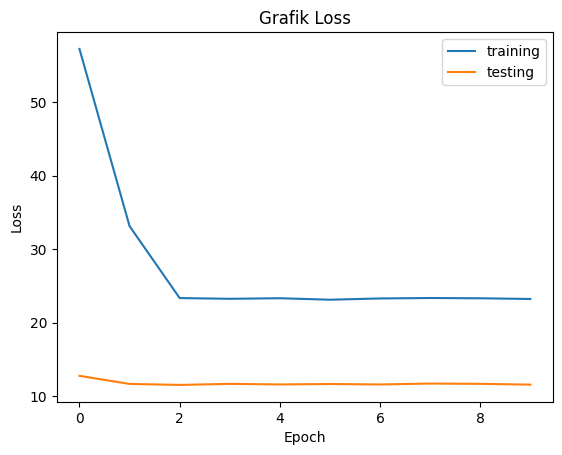

In [ ]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(loss_training, label="training")
plt.plot(loss_testing, label="testing")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Grafik Loss')
plt.legend()

Text(0.5, 1.0, 'Grafik Akurasi Testing')

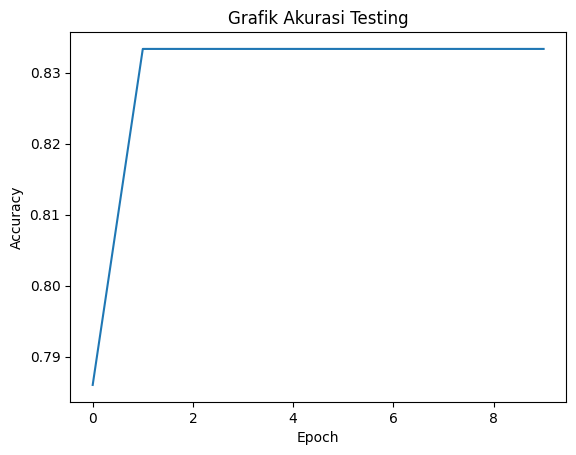

In [ ]:
plt.figure()
plt.plot(accuracy_testing)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Grafik Akurasi Testing')

Text(0.5, 1.0, 'Grafik F1 Score Testing')

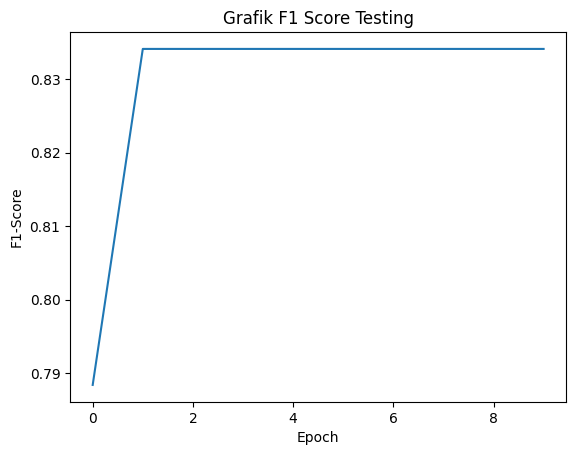

In [ ]:
plt.figure()
plt.plot(f1_score_testing)
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.title('Grafik F1 Score Testing')

In [ ]:
tabel_hasil = pd.DataFrame(range(1, 11), columns=['ke-'])
tabel_hasil["loss_training"] = loss_training
tabel_hasil["loss_testing"] = loss_testing
tabel_hasil["accuracy"] = accuracy_testing
tabel_hasil["F1-Score"] = f1_score_testing

In [ ]:
tabel_hasil.head()

,ke-,loss_training,loss_testing,accuracy,F1-Score
0,1,57.224167,12.751031,0.786036,0.788419
1,2,33.119650,11.648383,0.833333,0.834081
2,3,23.329664,11.512965,0.833333,0.834081
3,4,23.228987,11.658142,0.833333,0.834081
4,5,23.307081,11.577494,0.833333,0.834081


In [ ]:
tabel_hasil.to_csv("123ROBERTA datasetjibran, adam, 2e-5, bs 16, 10 epoch.csv")